In [ ]:
!pip install imutils

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
INIT_LR = 1e-4
EPOCHS = 14
BS = 32

In [ ]:
print(os.listdir("../input"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
imagePaths = list(paths.list_images('/content/drive/My Drive/mask dataset/maskdataset/with_mask'))

print(len(imagePaths))


2002


In [ ]:
imagePaths = list(paths.list_images('/content/drive/My Drive/mask dataset/maskdataset/dataset/without_mask'))

print(len(imagePaths))


1926


In [ ]:
imagePathsMask = list(paths.list_images('/content/drive/My Drive/mask dataset/maskdataset/dataset/with_mask'))

print(type(imagePathsMask))

<class 'list'>


In [ ]:
imagePathsWoMask = list(paths.list_images('/content/drive/My Drive/mask dataset/maskdataset/dataset/without_mask'))

print(type(imagePathsWoMask))

<class 'list'>


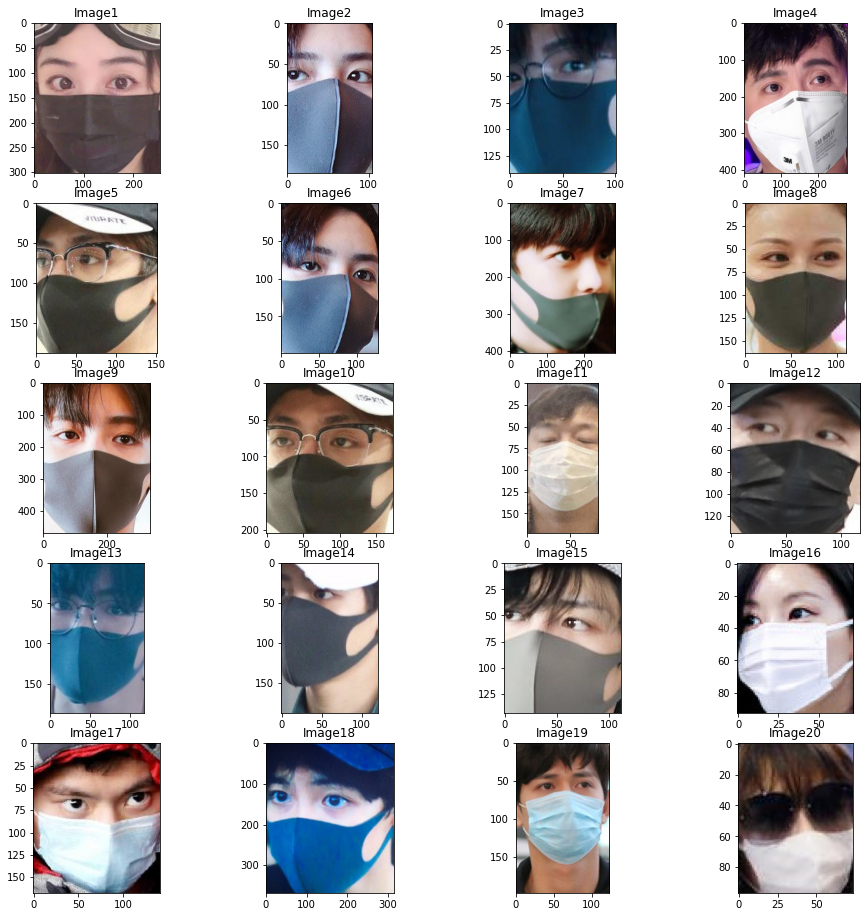

In [ ]:
import matplotlib.pyplot as plt
k=1
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    plt.title('Image'+str(k))
    t=plt.imread(imagePathsMask[k])
    plt.imshow(t)
    k+=1

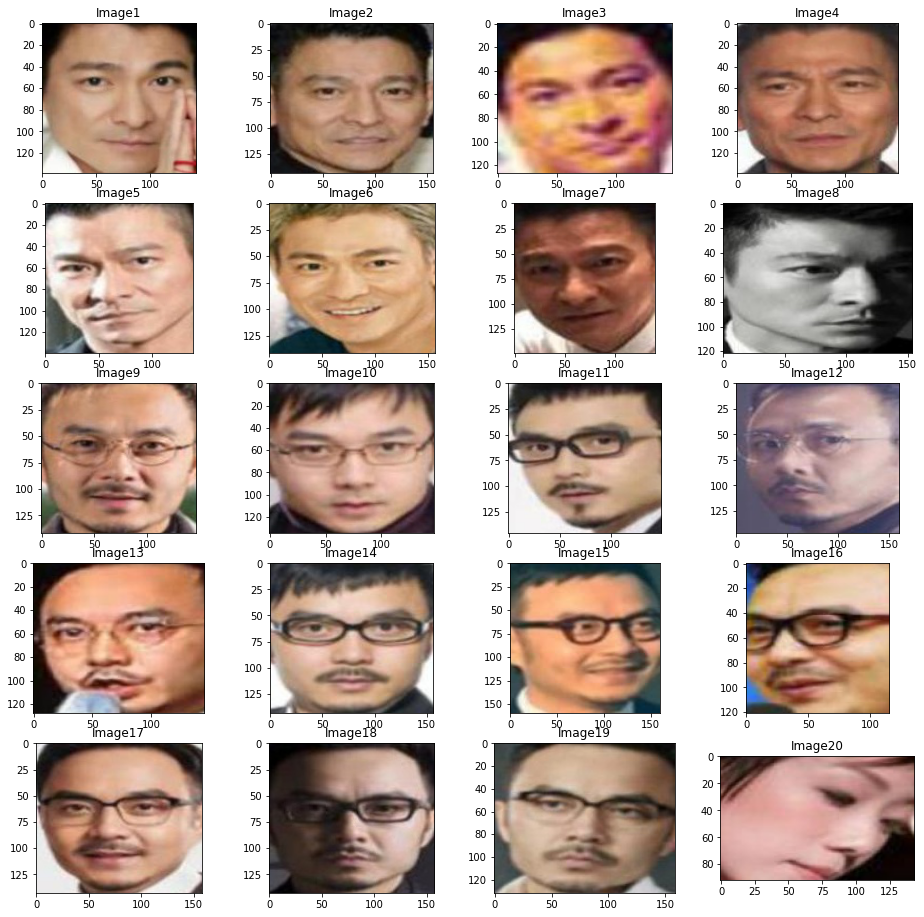

In [ ]:
import matplotlib.pyplot as plt
k=1
imagenumber=50
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,5):
  for y in range(0,4):
    plt.subplot(5,4,k)
    plt.title('Image'+str(k))
    t=plt.imread(imagePathsWoMask[imagenumber])
    plt.imshow(t)
    k+=1
    imagenumber+=1

In [ ]:
data = []
labels = []

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/drive/My Drive/mask dataset/maskdataset/dataset/with_mask'))
# loop over the image paths
for imagePath in imagePaths:
	# label
	label ="with"

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)



In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/drive/My Drive/mask dataset/maskdataset/dataset/without_mask'))

print(len(imagePaths))
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label ="without"# imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)



In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
print(len(data))
print(len(labels))

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
labels.shape

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, stratify=labels, random_state=42)


In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=10)

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
trainlabels=[]
for x,y in trainY:
    if(x==1):
        trainlabels.append(0)
    else:
        trainlabels.append(1)
        

In [ ]:
testlabels=[]
for x,y in testY:
    if(x==1):
        testlabels.append(0)
    else:
        testlabels.append(1)
        

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testlabels, predIdxs)

In [ ]:
yt=model.predict(trainX, batch_size=BS)
yt=np.argmax(yt,axis=1)

In [ ]:
#roc_auc curve for training data
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(trainlabels,yt )
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#roc_auc curve for test data
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testlabels, predIdxs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# loading model stored in .h5 format
from tensorflow.keras.models import load_model
model=load_model('/content/drive/My Drive/mask_model.model')

In [ ]:
data=[]
test_image_path=list(paths.list_images('/content/drive/My Drive/groupmembermask'))
print(test_image_path)
for imagePath in test_image_path:
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)


['/content/drive/My Drive/groupmembermask/pranav.jpg', '/content/drive/My Drive/groupmembermask/jaanwar.jpg', '/content/drive/My Drive/groupmembermask/Nikhil.jpg', '/content/drive/My Drive/groupmembermask/ss.jpg', '/content/drive/My Drive/groupmembermask/apoorv.jpeg', '/content/drive/My Drive/groupmembermask/marro.jpg']


In [ ]:
data=np.array(data,dtype='float32')

In [ ]:
pred=model.predict(data, batch_size=32)
pred = np.argmax(pred, axis=1)

In [ ]:
print(pred)

[0 0 0 0 1 1]


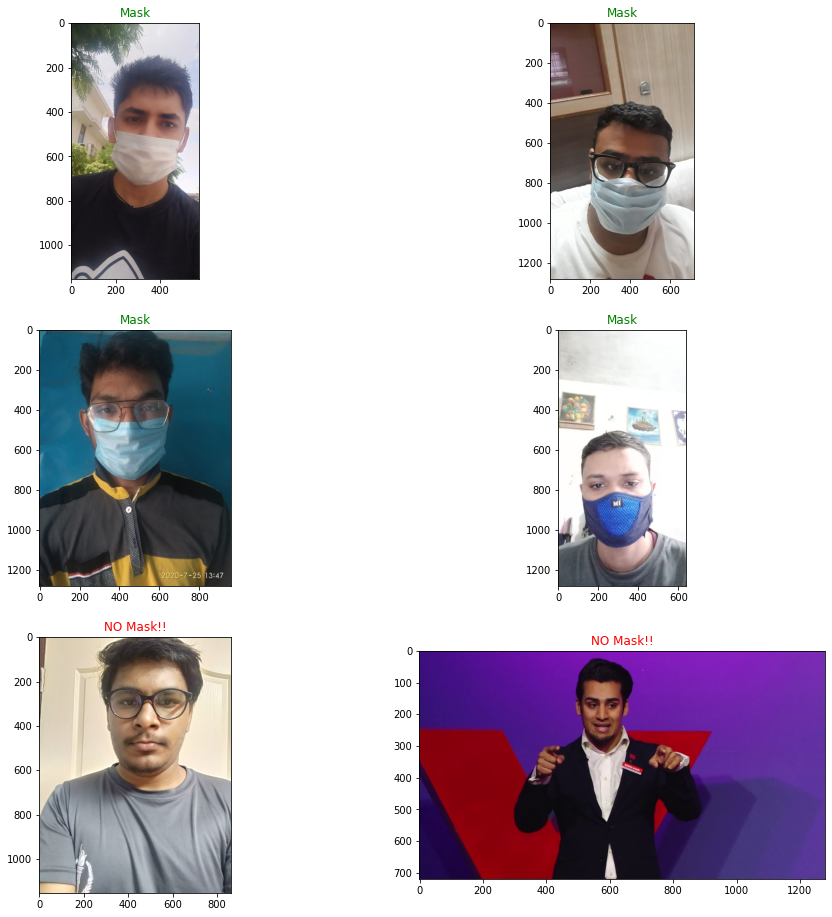

In [ ]:
import matplotlib.pyplot as plt
k=1
imagenumber=0
plt.figure(figsize=(16,16))
sub="20"
for x in range(0,3):
  for y in range(0,2):
    plt.subplot(3,2,k)
    s=""
    if(pred[k-1]==0):
      s="Mask"
      c='g'
    else:
      s="NO Mask!!"
      c='r'
    pob=plt.title(s)
    plt.setp(pob,color=c)
    t=plt.imread(test_image_path[imagenumber])
    plt.imshow(t)
    k+=1
    imagenumber+=1
